<h1 align="center"> Statistics and Financial Data Analysis </h1>




SARIMA Models Continuation
===

In [1]:
%reset -f

In [2]:
#import pandas_datareader as pd_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm
import pandas_datareader as pd_data

In [3]:
# Importing the Time Series Analysis module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as sm_tools

In [4]:
import statsmodels.tsa as st
print(sm.__version__)

0.14.0


In [145]:
# ! pip install pmdarima
# ! pip install arch

In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import pmdarima as pm
from datetime import datetime
# For splines
import patsy
from patsy import dmatrix
from statsmodels.graphics.tsaplots import plot_predict

In [7]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
def plot_diagnosticsTight3(data,df=0):

    fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,10))

    ax1.hist(data, bins =40,color='m', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
    ax1.grid()
    ax1.set_title("Hist Resid")

    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Data")

    fig = plot_acf(data,lags=40,zero=False, ax = ax3,use_vlines = True)
    ax3.grid()

    logData = int(np.floor(np.log(len(data))))
    ljbox_test = sm.stats.acorr_ljungbox(data,logData,model_df=df)

    ax4.plot(ljbox_test['lb_pvalue'])
    ax4.axhline(y=0.05, color='r',ls='--')
    ax4.set_title("LB test")
    ax4.grid()

    fig = sm.qqplot(data, line='q', ax = ax5)
    ax5.grid()

    ax6.plot(data*data)
    ax6.grid()
    ax6.set_title("Data Sqr")

    plt.tight_layout()

Seasonality with AEMO Data
===

In [10]:
AEMO = pd.read_csv('AEMOPriceDataSimple.csv', index_col = 0)
SydTemp = pd.read_csv('SydTemp.csv', index_col = 0)
SydTemp.head()

,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C)
Product code,,,,,,
IDCJAC0010,66062.0,1859.0,1.0,1.0,24.4,14.5
IDCJAC0010,66062.0,1859.0,1.0,2.0,24.4,15.7
IDCJAC0010,66062.0,1859.0,1.0,3.0,24.2,15.3
IDCJAC0010,66062.0,1859.0,1.0,4.0,24.7,17.4
IDCJAC0010,66062.0,1859.0,1.0,5.0,24.6,16.9


In [24]:
AEMO

,RRP
Date,
01/01/13,46.15
02/01/13,47.72
03/01/13,48.08
04/01/13,49.65
05/01/13,51.56
...,...
27/12/13,49.10
28/12/13,49.21
29/12/13,47.13


In [15]:
# 1) Slice SydTemp data frame to select years 2013 and 2014, creat oneYearTemp and nextYearTemp
# 2) Display result

oneYearTemp = SydTemp[SydTemp['Year']==2013]
nextYearTemp = SydTemp[SydTemp['Year']==2014]
nextYearTemp.head()


,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Minimum temperature (Degree C)
Product code,,,,,,
IDCJAC0010,66062.0,2014.0,1.0,1.0,27.1,20.5
IDCJAC0010,66062.0,2014.0,1.0,2.0,36.5,22.3
IDCJAC0010,66062.0,2014.0,1.0,3.0,26.2,21.0
IDCJAC0010,66062.0,2014.0,1.0,4.0,27.5,20.1
IDCJAC0010,66062.0,2014.0,1.0,5.0,26.0,20.8


In [16]:
# 1) Select for oneYearTemp max and min temperature and get mean temp, storying under meanTemp
# 2) Display your df

maxTemp = oneYearTemp['Maximum temperature (Degree C)']
minTemp = oneYearTemp['Minimum temperature (Degree C)']
meanTemp = (maxTemp + minTemp)*0.5
len(meanTemp)

365

In [17]:
# 1) Select for nextYearTemp max and min temperature and get mean temp, storying under meanTemp
# 2) Display your df

nextYearTemp = SydTemp[SydTemp['Year']==2014]
maxTempNext = nextYearTemp['Maximum temperature (Degree C)']
minTempNext = nextYearTemp['Minimum temperature (Degree C)']
meanTempNext = (maxTempNext + minTempNext)*0.5
meanTempNext.values[0]

23.8

In [18]:
# Now get year from oneYearTemp and store it in variable 'year', display

#names = ['date','meanTemp']

N = len(oneYearTemp)
dt = []
year = oneYearTemp.iloc[0][1]
type(year)

numpy.float64

In [19]:
# Convert dates in data frame to datetime

for i in range(N):
    month = oneYearTemp.iloc[i][2]
    day = oneYearTemp.iloc[i][3]
    dt.append(datetime(year=int(year), month = int(month), day= int(day)))

In [20]:
# Now create a dataframe with your datetime data and your meanTemp values
# Remember to set the index to the datetime column
# display

myList = [dt, meanTemp.values]
myNames = ['date','meanTemp']
myDict = dict(zip(myNames, myList))
dfMeanTemp = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})

In [21]:
dfMeanTemp.head()

,date,meanTemp
0,2013-01-01,23.20
1,2013-01-02,21.60
2,2013-01-03,21.60
3,2013-01-04,22.45
4,2013-01-05,24.60


In [25]:
dfMeanTemp

,date,meanTemp
0,2013-01-01,23.20
1,2013-01-02,21.60
2,2013-01-03,21.60
3,2013-01-04,22.45
4,2013-01-05,24.60
...,...,...
360,2013-12-27,21.35
361,2013-12-28,22.45
362,2013-12-29,22.30
363,2013-12-30,21.50


In [26]:
dfMeanTemp.set_index(dfMeanTemp['date'], inplace = True)
dfMeanTemp.head()
del dfMeanTemp['date']

In [27]:
dfMeanTemp.head()

,meanTemp
date,
2013-01-01,23.20
2013-01-02,21.60
2013-01-03,21.60
2013-01-04,22.45
2013-01-05,24.60


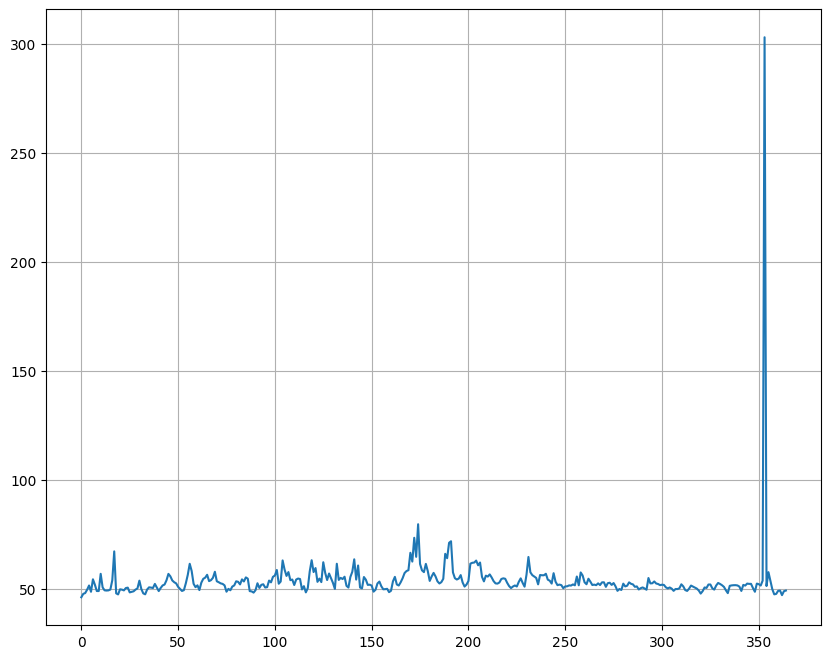

In [28]:
plt.figure(1, figsize=(10,8))
plt.plot(AEMO['RRP'].values)
plt.grid()
plt.show()

In [29]:
# Remove outlier
AEMO[AEMO['RRP']==AEMO['RRP'].max()]=AEMO['RRP'].mean()

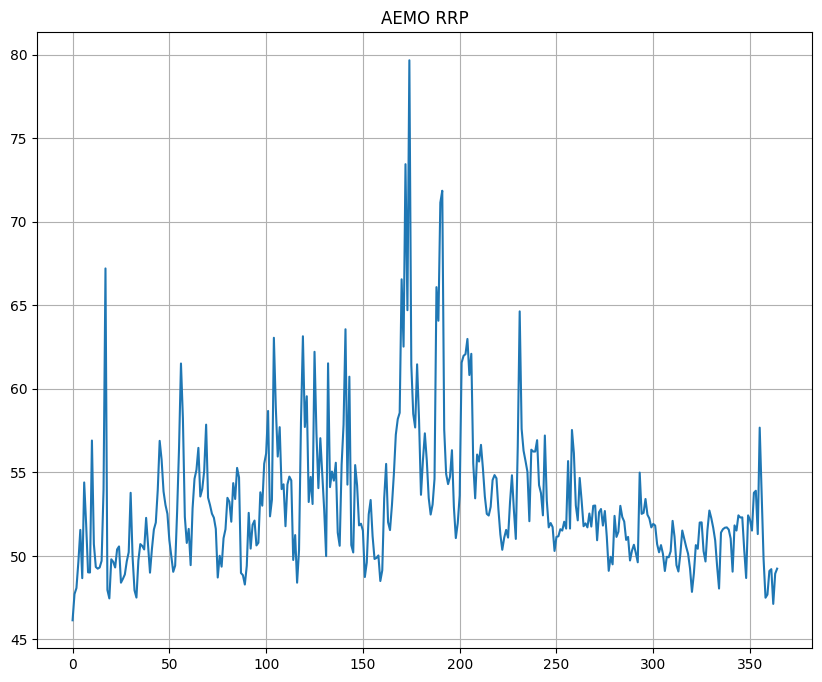

In [30]:
plt.figure(1, figsize=(10,8))
plt.plot(AEMO['RRP'].values)
plt.title("AEMO RRP")
plt.grid()

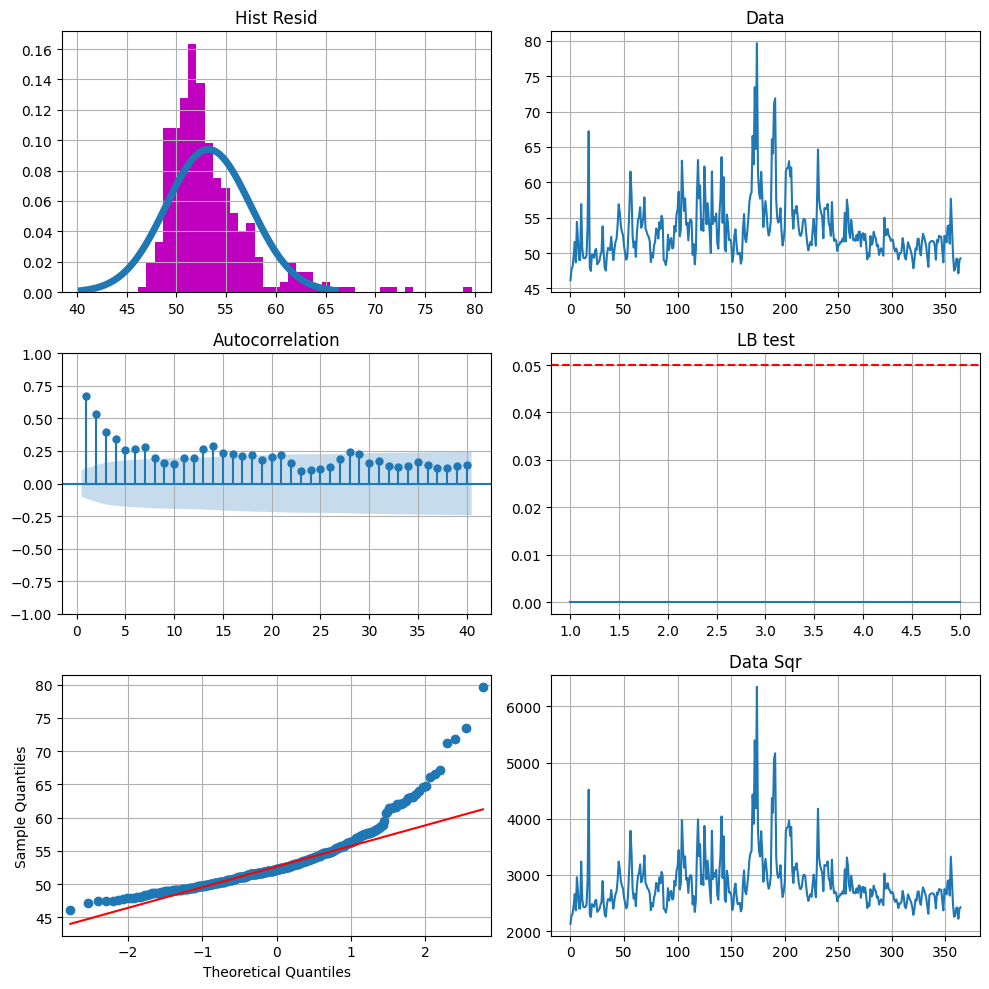

In [33]:
# Check characteristics of process - this is not really model diagnostics, I'm simply using the graphing functionality .

price = AEMO['RRP'].values
plot_diagnosticsTight3(price)

In [67]:
# Reject Unit Root
test = adfuller(price) #maxlag = 5)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -2.847700
p-value: 0.051777
Critical Values:i/
	1%: -3.45
	5%: -2.87
	10%: -2.57


In [68]:
# But Stationarity is rejected.
num = len(price)
maxLag = np.log(num)
test = kpss(price) #nlags = int(maxLag))
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.503648
p-value: 0.040845
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


Examples for Creating Factors and Carrying out Analysis Accordingly
===

In [36]:
# Create data frames to combine relevant variables for analysis.
N = len(price)
weekly = np.zeros(N)
weekly2 = np.zeros(N)
yearly = np.zeros(N)
yearly2 = np.zeros(N)
meanTempV = np.zeros(N)

for i in range(N):
    yearly[i] = np.sin(2*np.pi*i/365) # it means it will repeat every 365 days
    yearly2[i] = np.cos(2*np.pi*i/365)  # it means it will repeat every 365 days
    weekly[i] = np.sin(2*np.pi*i/7)  # it means it will repeat every 7 days
    weekly2[i] = np.cos(2*np.pi*i/7)  # it means it will repeat every 7 days
    meanTempV[i] = meanTemp.values[i]
    # Create dataframe
myList = [dfMeanTemp.index, meanTempV, yearly, yearly2, weekly, weekly2]
names = ['date','meanTemp','y1','y2','w1','w2']
myDict = dict(zip(names, myList))
df = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})

df.set_index(df['date'], inplace = True)
df.head()
del df['date']



# Generate data to feed to forecast (required for exogeneous variables)
def df_sincosFit(N,w1,w2,y1,y2):
    weeklyFit = np.zeros(N)
    weekly2Fit = np.zeros(N)
    yearlyFit = np.zeros(N)
    yearly2Fit = np.zeros(N)
    meanTempFit = np.zeros(N)

    for i in range(N):
        yearlyFit[i] = y1*np.sin(2*np.pi*i/365)
        yearly2Fit[i] = y2*np.cos(2*np.pi*i/365)
        weeklyFit[i] = w1*np.sin(2*np.pi*i/7)
        weekly2Fit[i] = w2*np.cos(2*np.pi*i/7)
        if(i < len(meanTempNext)):
            meanTempFit[i] = meanTempNext.values[i]
        else:
            meanTempFit[i] = meanTempNext.values[len(meanTempNext)-1]
    # Create dataframe
    myList = [meanTempFit, yearlyFit, yearly2Fit, weeklyFit, weekly2Fit]
    names = ['meanTempFit','y1Fit','y2Fit','w1Fit','w2Fit']
    myDict = dict(zip(names, myList))
    dfFit = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})
    return dfFit



In [37]:
df.head()

,meanTemp,y1,y2,w1,w2
date,,,,,
2013-01-01,23.20,0.000000,1.000000,0.000000,1.000000
2013-01-02,21.60,0.017213,0.999852,0.781831,0.623490
2013-01-03,21.60,0.034422,0.999407,0.974928,-0.222521
2013-01-04,22.45,0.051620,0.998667,0.433884,-0.900969
2013-01-05,24.60,0.068802,0.997630,-0.433884,-0.900969


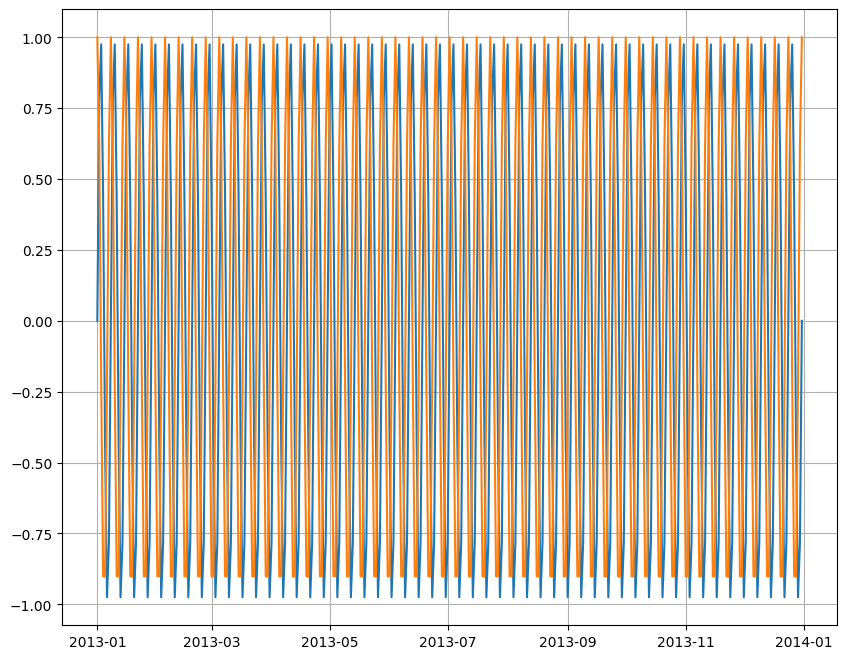

In [40]:
plt.figure(1, figsize=(10,8))
plt.plot(df[['w1','w2']])
plt.grid()
plt.show()

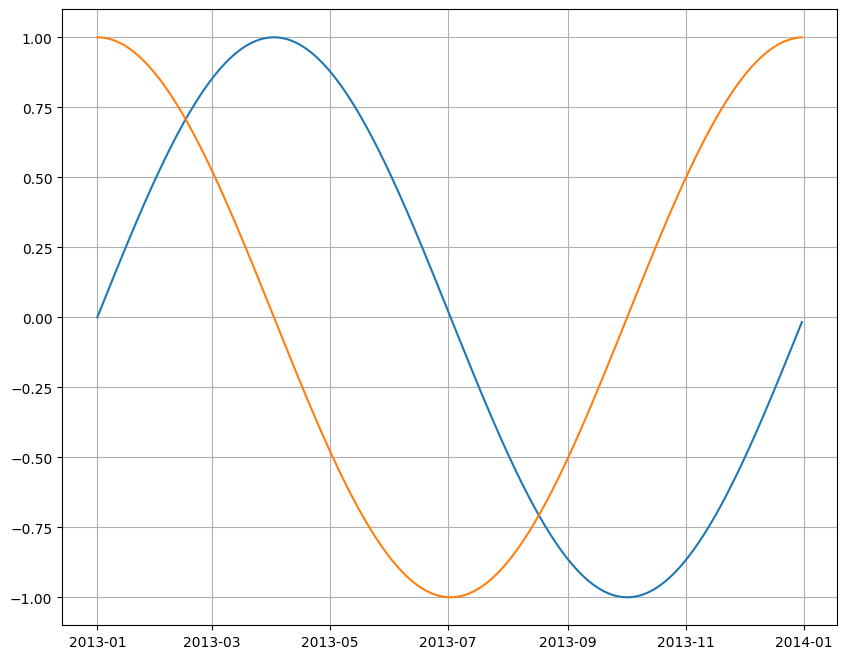

In [39]:
plt.figure(1, figsize=(10,8))
plt.plot(df[['y1','y2']])
plt.grid()
plt.show()

In [38]:
AEMO = pd.read_csv('AEMOPriceDataSimple.csv', index_col = 0)
# Remove outlier
AEMO[AEMO['RRP']==AEMO['RRP'].max()]=AEMO['RRP'].mean()
temp =AEMO.index[2]
print(temp)
print(type(temp))


03/01/13
<class 'str'>


In [41]:
for i in range(0,1):
    temp = AEMO.index[i]
    dt = datetime.strptime(temp, '%d/%m/%y')

In [42]:
#Quickly create cateogry to extract day of the week.

N = len(price)
y_pos = np.zeros(N)
for i in range(N):
    temp =AEMO.index[i]
    dt = datetime.strptime(temp, '%d/%m/%y')
    y_pos[i]= dt.weekday()
AEMO['DayWeek'] = y_pos
AEMO['DayWeek'].astype('category');


In [43]:
AEMO.head(10)

,RRP,DayWeek
Date,,
01/01/13,46.15,1.0
02/01/13,47.72,2.0
03/01/13,48.08,3.0
04/01/13,49.65,4.0
05/01/13,51.56,5.0
06/01/13,48.67,6.0
07/01/13,54.40,0.0
08/01/13,51.93,1.0
09/01/13,49.02,2.0


<Axes: title={'center': 'RRP'}, xlabel='[DayWeek]'>

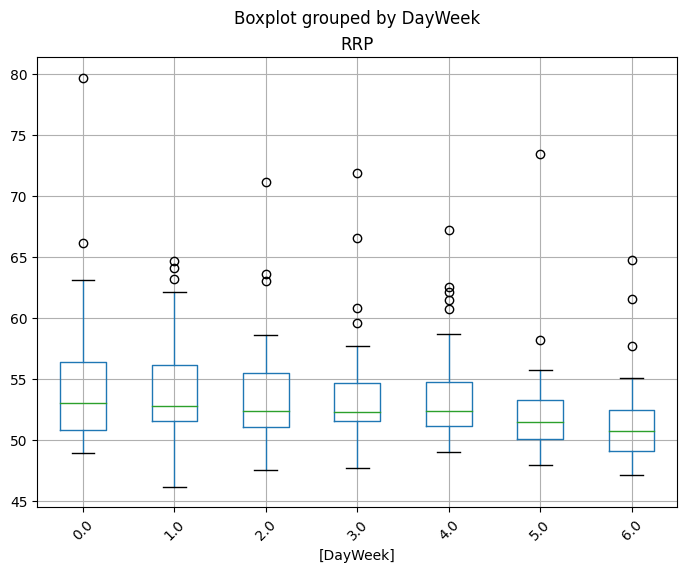

In [44]:
AEMO.boxplot(by='DayWeek',rot=45, fontsize=10)

In [45]:
del AEMO['DayWeek']

In [46]:
print(pd.Timestamp(AEMO.index[2]))

2013-03-01 00:00:00


In [47]:
AEMO.head(5)

,RRP
Date,
01/01/13,46.15
02/01/13,47.72
03/01/13,48.08
04/01/13,49.65
05/01/13,51.56


It makes sense to analyse temperature data by grouping by Months
===

In [ ]:
# dt is the Datetime object - this is one way to get all methods:
#dt.__dir__()

In [ ]:
# Or use "tab" to display methods
# dt.

In [49]:
#Quickly create cateogry to extract month.

N = len(price)
y_pos = np.zeros(N)
for i in range(N):
    temp =AEMO.index[i]
    dt = datetime.strptime(temp, '%d/%m/%y')
    y_pos[i]= dt.month
AEMO['Month'] = y_pos
AEMO['Month'].astype('category');
AEMO.tail()

,RRP,Month
Date,,
27/12/13,49.10,12.0
28/12/13,49.21,12.0
29/12/13,47.13,12.0
30/12/13,48.94,12.0
31/12/13,49.24,12.0


This is a super nice plot to show Heteroskedasticity of residuals and how there appears to be seasonality
===

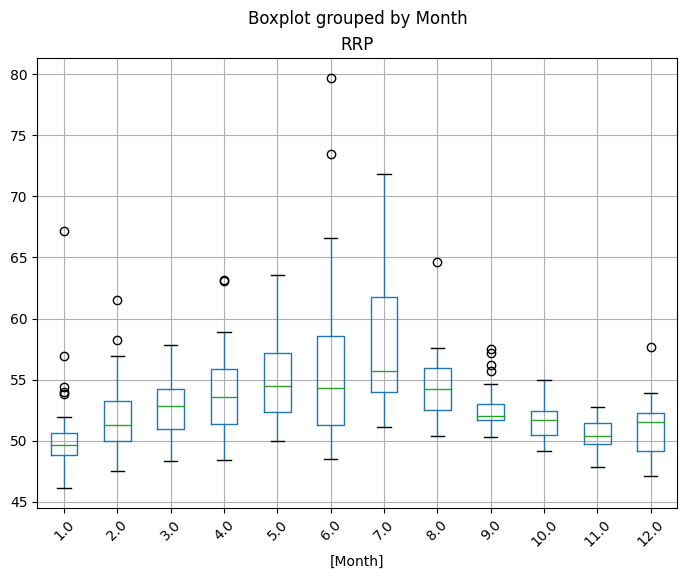

In [50]:
AEMO.boxplot(by='Month',rot=45, fontsize=10);
#plt.savefig("Boxplot_AEMO_MONTH")

In [51]:
N = len(dfMeanTemp)
y_pos = np.zeros(N)
tempHigh=np.zeros(N)

for i in range(N):
    temp =dfMeanTemp.index[i]
    y_pos[i]= temp.month
    if ((y_pos[i] < 4) or (y_pos[i] >8)):
        tempHigh[i] = 1
    else:
        tempHigh[i] = 0

dfMeanTemp['Month_high']=tempHigh
dfMeanTemp['Price'] = AEMO['RRP'].values

dfMeanTemp[:95]

,meanTemp,Month_high,Price
date,,,
2013-01-01,23.20,1.0,46.15
2013-01-02,21.60,1.0,47.72
2013-01-03,21.60,1.0,48.08
2013-01-04,22.45,1.0,49.65
2013-01-05,24.60,1.0,51.56
...,...,...,...
2013-04-01,20.85,0.0,49.41
2013-04-02,21.25,0.0,52.58
2013-04-03,17.80,0.0,50.44


In [52]:
X1 = dfMeanTemp[['meanTemp','Month_high']]
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     52.18
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           1.23e-20
Time:                        16:02:26   Log-Likelihood:                -999.54
No. Observations:                 365   AIC:                             2005.
Df Residuals:                     362   BIC:                             2017.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.7636      1.147     50.352      0.0

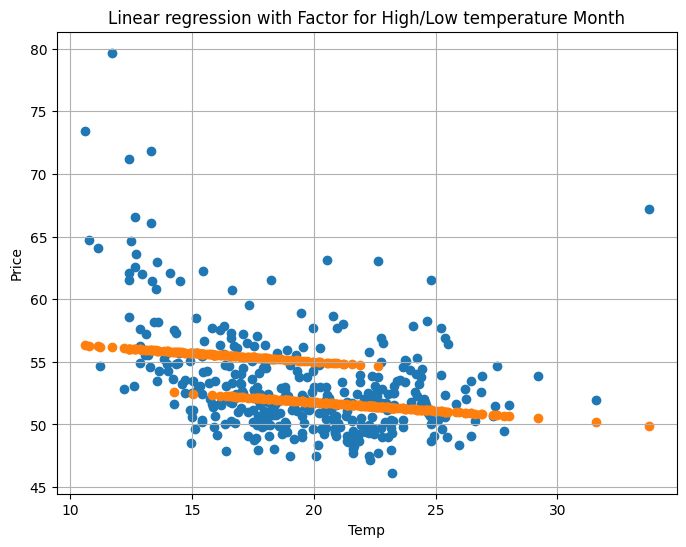

In [53]:
fitted = lm.fittedvalues
dfMeanTemp['fitted'] = fitted
plt.scatter(dfMeanTemp['meanTemp'],dfMeanTemp['Price'])
plt.scatter(dfMeanTemp['meanTemp'],dfMeanTemp['fitted'])
plt.title('Linear regression with Factor for High/Low temperature Month')
plt.xlabel('Temp')
plt.ylabel('Price')
plt.grid()

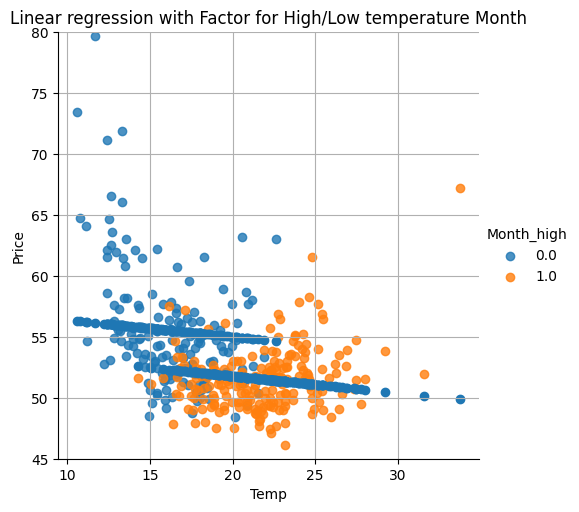

In [54]:
import seaborn as sns
lmplot = sns.lmplot(dfMeanTemp, x = 'meanTemp', y ='Price', hue='Month_high', fit_reg=False)
axes = lmplot.axes
axes[0,0].set_ylim(45,80)
plt.scatter(dfMeanTemp['meanTemp'],dfMeanTemp['fitted'])
plt.title('Linear regression with Factor for High/Low temperature Month')
plt.xlabel('Temp')
plt.ylabel('Price')
plt.grid()
plt.show()

Text(0, 0.5, 'Residuals')

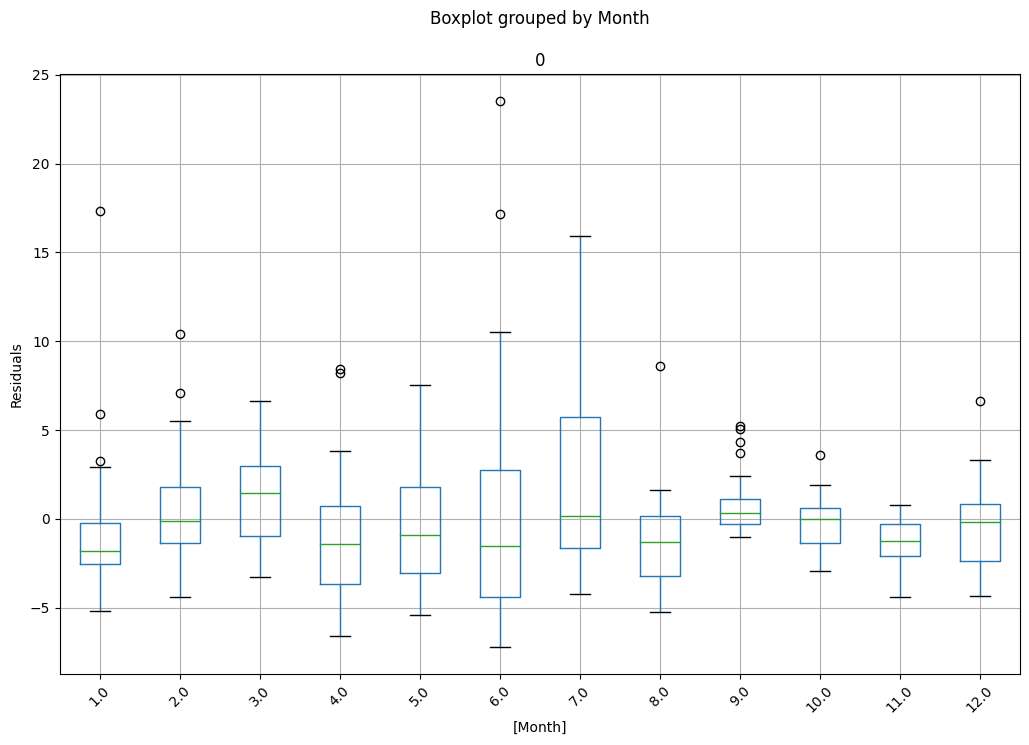

In [55]:
N = len(lm.resid)
y_pos = np.zeros(N)

temp = lm.resid.to_frame()

for i in range(N):
    y_pos[i]= lm.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month',rot=45, fontsize=10,figsize=(12,8));
plt.ylabel('Residuals')

Examples of using periodic functions like Sin and Cos to model seasonality
===

In [56]:
# Fit a linear regression

X1 = df[['meanTemp']]
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
y_fitted= lm.fittedvalues
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     63.62
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           1.99e-14
Time:                        16:03:31   Log-Likelihood:                -1016.3
No. Observations:                 365   AIC:                             2037.
Df Residuals:                     363   BIC:                             2044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.2526      1.028     59.596      0.0

Text(0, 0.5, 'Residuals')

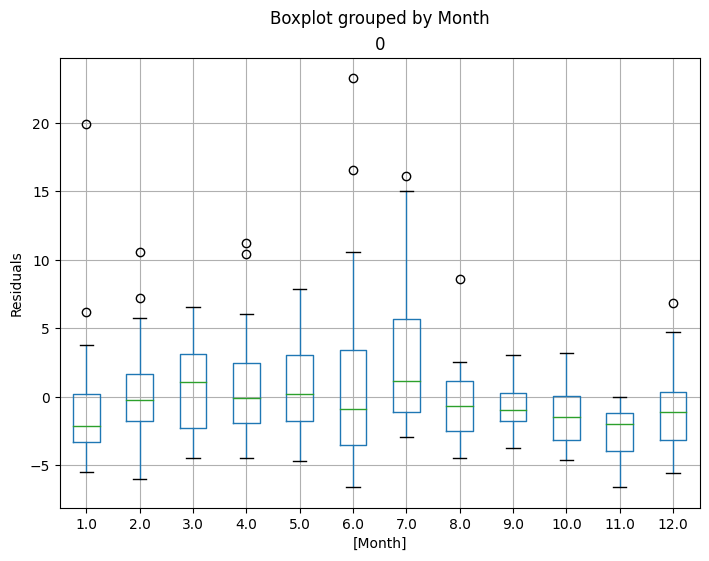

In [57]:

N = len(lm.resid)
y_pos = np.zeros(N)

temp = lm.resid.to_frame()

for i in range(N):
    y_pos[i]= lm.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month')
plt.ylabel('Residuals')

In [58]:
# Fit a linear regression

X1 = df[['meanTemp','y1','y2']]
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
y_fitted= lm.fittedvalues
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     40.61
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           1.24e-22
Time:                        16:03:48   Log-Likelihood:                -992.70
No. Observations:                 365   AIC:                             1993.
Df Residuals:                     361   BIC:                             2009.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.4841      1.520     35.856      0.0

Text(0, 0.5, 'Residuals')

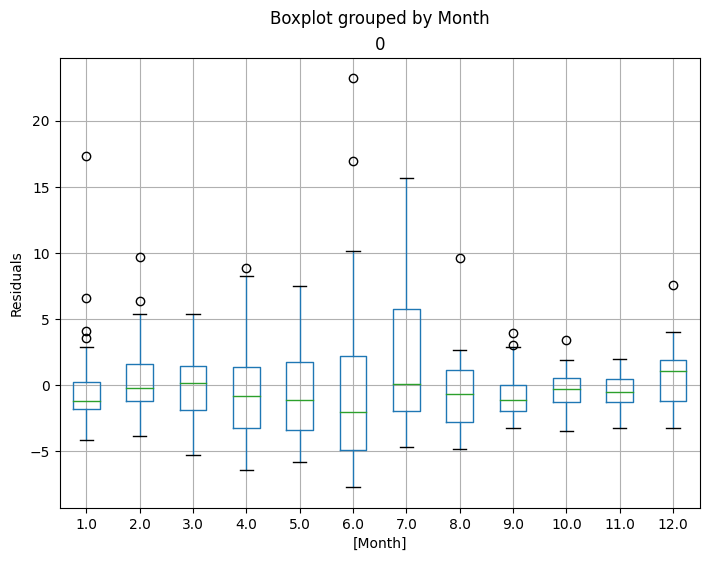

In [59]:

N = len(lm.resid)
y_pos = np.zeros(N)

temp = lm.resid.to_frame()

for i in range(N):
    y_pos[i]= lm.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month')
plt.ylabel('Residuals')


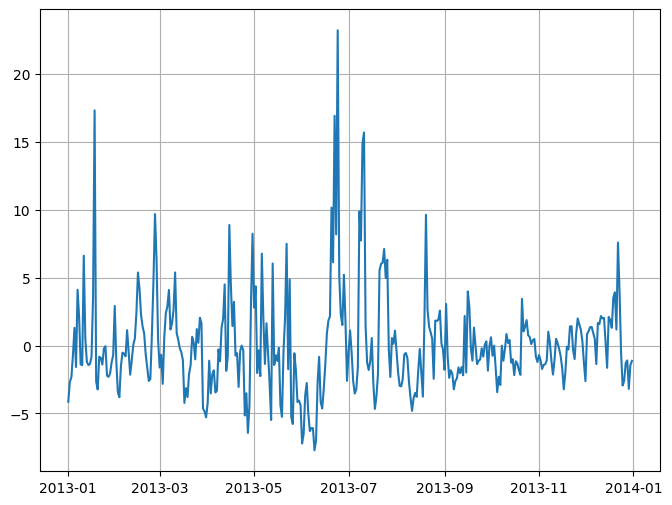

In [60]:
plt.plot(lm.resid)
plt.grid()
plt.show()

In [69]:
# So can fit an ARMA type model
price1 = price - price.mean()
results = pm.auto_arima(price, X = df[['y1','y2']], trace = True, seasonal=False, stationary = False, stepwise = False,with_intercept=True, information_criterion='aic', start_q=0, max_p = 6, max_q = 1,d=0)
# Order selected is given in summary
print(results.summary())
# This chooses AR 2 model for the mean

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1994.119, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1902.981, Time=0.63 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1855.823, Time=1.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1854.973, Time=3.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1854.323, Time=1.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1855.978, Time=1.79 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1855.010, Time=1.87 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1857.002, Time=1.12 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1856.885, Time=0.74 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1858.874, Time=1.57 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1856.849, Time=1.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 14.319 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(2, 0, 0) 

In [74]:
?pm.auto_arima

In [71]:
# Fitting seasonal functions as regression external factors in conjunction with ARIMA.

y = price

model = ARIMA(y, exog = df[['y1','y2']],order=(2,0,0))
results = model.fit()
print(results.summary());

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -921.161
Date:                Wed, 15 Nov 2023   AIC                           1854.322
Time:                        16:14:22   BIC                           1877.722
Sample:                    01-01-2013   HQIC                          1863.622
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.1968      0.585     90.956      0.000      52.050      54.343
y1             0.5572      0.781      0.714      0.475      -0.973       2.087
y2            -3.0036      0.557     -5.393      0.0

In [72]:
price[-1]

49.24

In [73]:
?ARIMA

Text(0, 0.5, 'Residuals')

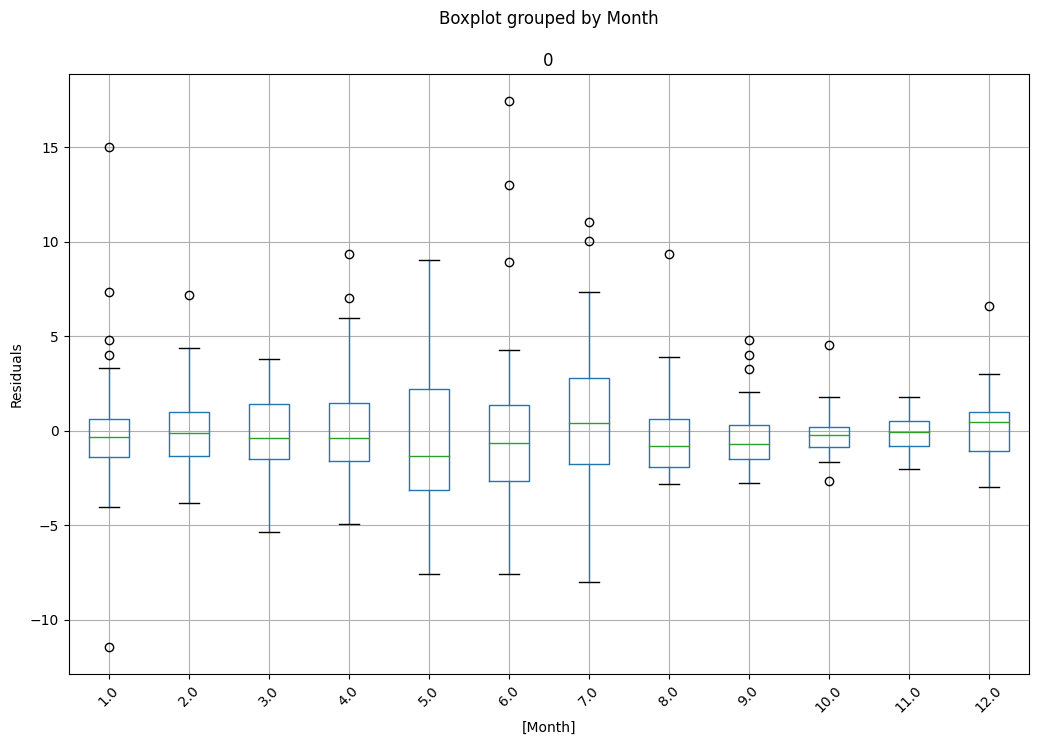

In [75]:

N = len(results.resid)
y_pos = np.zeros(N)

temp = results.resid.to_frame()

for i in range(N):
    y_pos[i]= results.resid.index[i].month
temp['Month'] = y_pos
temp['Month'].astype('category');
temp.head(20)

temp.boxplot(by='Month',rot=45, fontsize=10,figsize=(12,8));
plt.ylabel('Residuals')


In [77]:
# reject unit root
test = adfuller(results.resid)
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:i/')
for item, value in test[4].items():
    print('\t%s: %.2f' % (item, value))

ADF Statistic: -18.970457
p-value: 0.000000
Critical Values:i/
	1%: -3.45
	5%: -2.87
	10%: -2.57


In [78]:
# cannot reject stationarity
test = kpss(results.resid)
print('KPSS Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for item, value in test[3].items():
    print('\t%s: %.2f' % (item, value))

KPSS Statistic: 0.030607
p-value: 0.100000
Critical Values:
	10%: 0.35
	5%: 0.46
	2.5%: 0.57
	1%: 0.74


In [79]:
results.params

const     53.196759
y1         0.557212
y2        -3.003641
ar.L1      0.509824
ar.L2      0.097613
sigma2     9.101815
dtype: float64

In [80]:
lastIdx = len(results.fittedvalues)
print(lastIdx)

# I need to create data to feed into exogenous matrix to be used for prediction:

startPt = 0
endPt = 730
nForecast = endPt - lastIdx

w1 = 0
w2 = 0
y1 = 1
y2 = 1
exog = df_sincosFit(nForecast + 1, w1, w2, y1, y2)
exog

365


,meanTempFit,y1Fit,y2Fit,w1Fit,w2Fit
0,23.80,0.000000e+00,1.000000,0.0,0.0
1,29.40,1.721336e-02,0.999852,0.0,0.0
2,23.60,3.442161e-02,0.999407,0.0,-0.0
3,23.80,5.161967e-02,0.998667,0.0,-0.0
4,23.40,6.880243e-02,0.997630,-0.0,-0.0
...,...,...,...,...,...
361,17.65,-6.880243e-02,0.997630,-0.0,-0.0
362,17.65,-5.161967e-02,0.998667,-0.0,-0.0
363,17.65,-3.442161e-02,0.999407,-0.0,0.0
364,17.65,-1.721336e-02,0.999852,-0.0,0.0


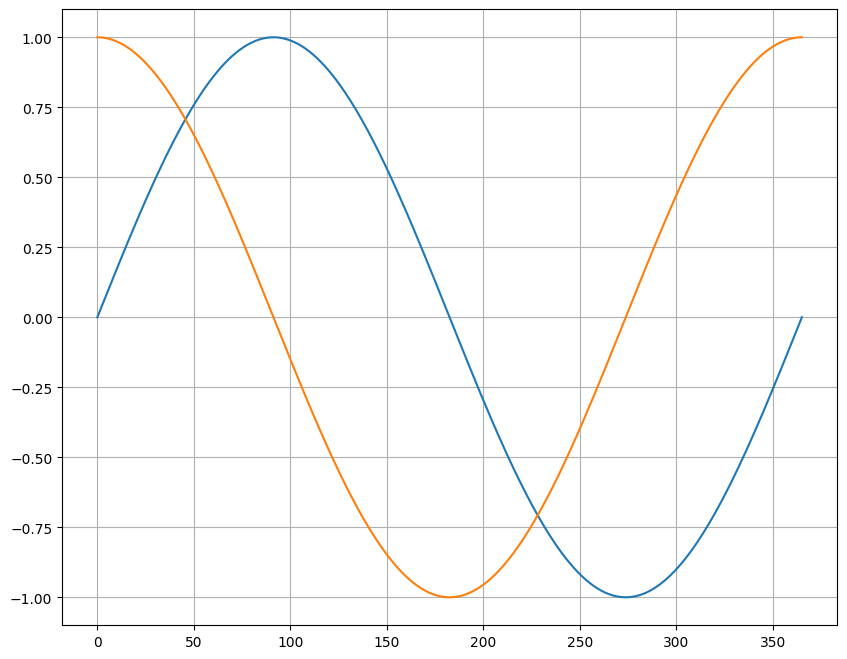

In [81]:
plt.figure(1, figsize=(10,8))
plt.plot(exog[['y1Fit','y2Fit']])
plt.grid()
plt.show()

<Axes: >

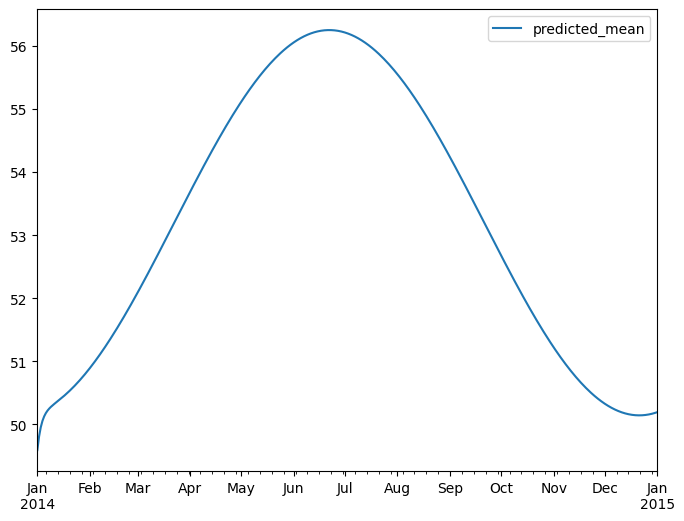

In [82]:
test = results.forecast(366,exog = exog[['y1Fit','y2Fit']])
test.plot(legend =True)

In [ ]:
# Forecast for the next 3 years
#forecast = result.predict(start = len(airline),  end = (len(airline)-1) + 3 * 12, typ = 'levels').rename('Forecast')

# Plot the forecast values
#airline['# Passengers'].plot(figsize = (12, 5), legend = True)
#forecast.plot(legend = True)

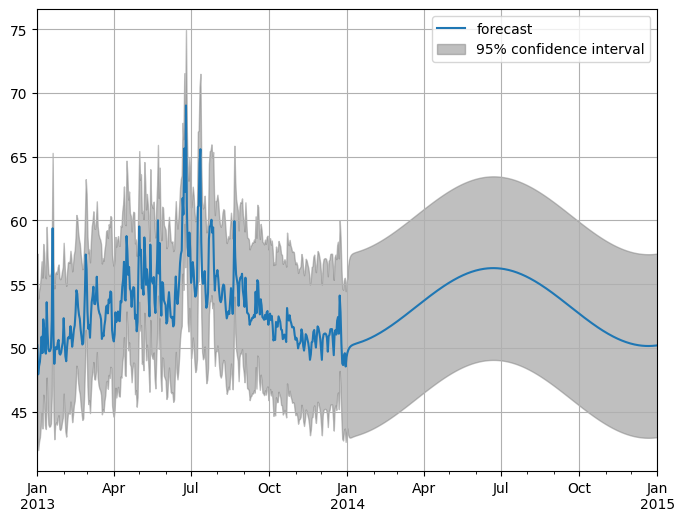

date
2013-01-01    50.193118
2013-01-02    47.918903
2013-01-03    48.553446
2013-01-04    48.895494
2013-01-05    49.736660
                ...    
2013-12-27    48.642845
2013-12-28    49.383062
2013-12-29    49.579947
2013-12-30    48.533772
2013-12-31    49.257390
Length: 365, dtype: float64

In [83]:
# This will proeduce the insampling,
# one-step prediction (fitted values) in addtion to one-step prediciton (mean)
# The mean is not constant! As we are overlayign it with the sin/cos periodic functions.

plot_predict(results, start=startPt,end=endPt , exog = exog[['y1Fit','y2Fit']], dynamic = False)
plt.grid()
plt.show()
results.fittedvalues

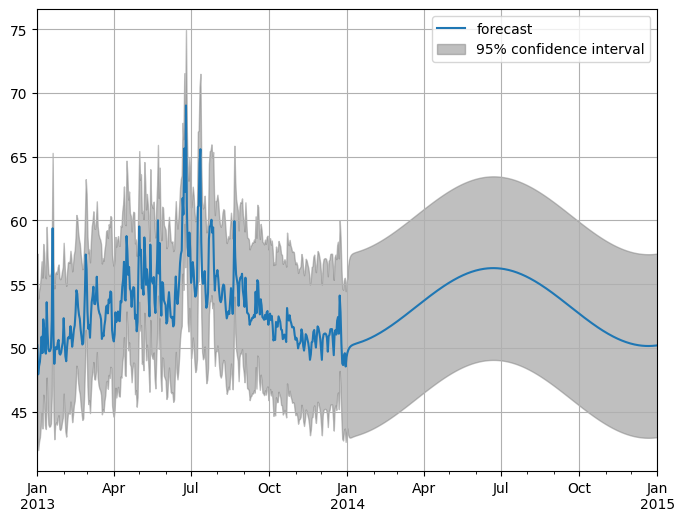

In [85]:
plot_predict(results, start=startPt,end=endPt ,exog = exog[['y1Fit','y2Fit']],dynamic = 400)
plt.grid()
plt.show()

In [84]:
exog

,meanTempFit,y1Fit,y2Fit,w1Fit,w2Fit
0,23.80,0.000000e+00,1.000000,0.0,0.0
1,29.40,1.721336e-02,0.999852,0.0,0.0
2,23.60,3.442161e-02,0.999407,0.0,-0.0
3,23.80,5.161967e-02,0.998667,0.0,-0.0
4,23.40,6.880243e-02,0.997630,-0.0,-0.0
...,...,...,...,...,...
361,17.65,-6.880243e-02,0.997630,-0.0,-0.0
362,17.65,-5.161967e-02,0.998667,-0.0,-0.0
363,17.65,-3.442161e-02,0.999407,-0.0,0.0
364,17.65,-1.721336e-02,0.999852,-0.0,0.0


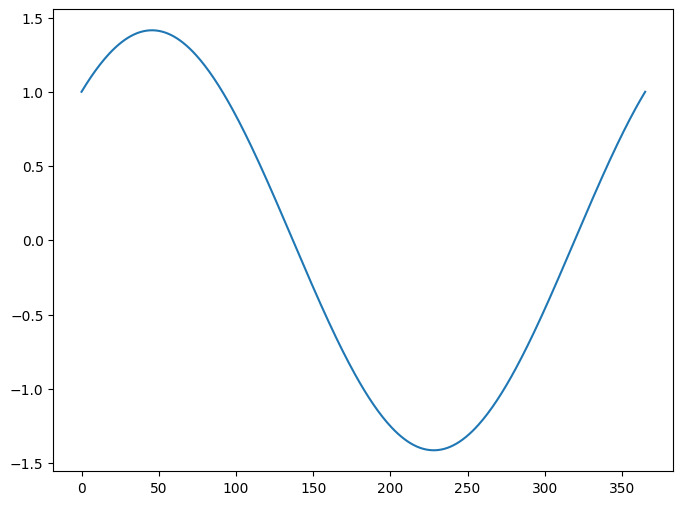

In [86]:
y = exog['y1Fit']+exog['y2Fit']
plt.plot(y)

In [87]:
df_sincosFit

<function __main__.df_sincosFit(N, w1, w2, y1, y2)>

In [88]:
# Fitting seasonal functions as regression external factors in conjunction with ARIMA.

# No temperature

model = ARIMA(price, exog = df[['w1','w2']], order=(1,0,1))
resultsARIMA = model.fit()
print(resultsARIMA.summary());

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -922.587
Date:                Wed, 15 Nov 2023   AIC                           1857.175
Time:                        16:37:29   BIC                           1880.574
Sample:                    01-01-2013   HQIC                          1866.474
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.0768      0.856     61.989      0.000      51.399      54.755
w1             0.6447      0.267      2.411      0.016       0.121       1.169
w2             0.8017      0.226      3.553      0.0

In [89]:
resultsARIMA.cov_params()

,const,w1,w2,ar.L1,ma.L1,sigma2
const,0.733137,0.014862,-0.016599,-0.002854,-0.009774,-0.164237
w1,0.014862,0.071500,-0.002798,-0.000425,0.000724,0.009980
w2,-0.016599,-0.002798,0.050901,-0.001091,0.002283,-0.003040
ar.L1,-0.002854,-0.000425,-0.001091,0.000663,-0.000934,-0.002203
ma.L1,-0.009774,0.000724,0.002283,-0.000934,0.002322,0.006297
sigma2,-0.164237,0.009980,-0.003040,-0.002203,0.006297,0.164323


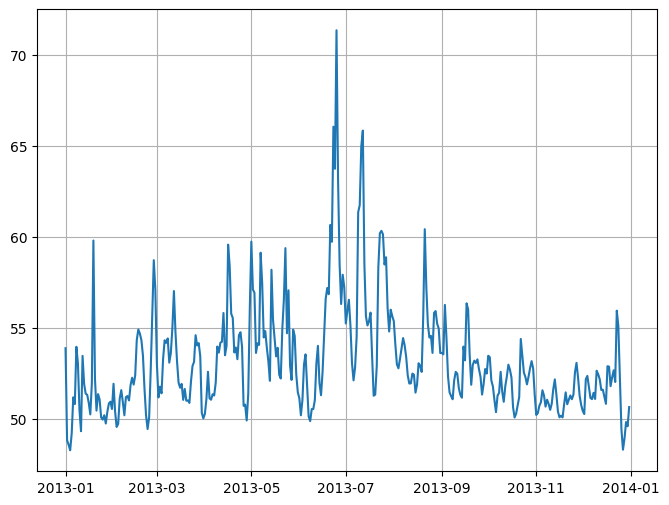

In [90]:
plt.plot(resultsARIMA.fittedvalues)
plt.grid()
plt.show()

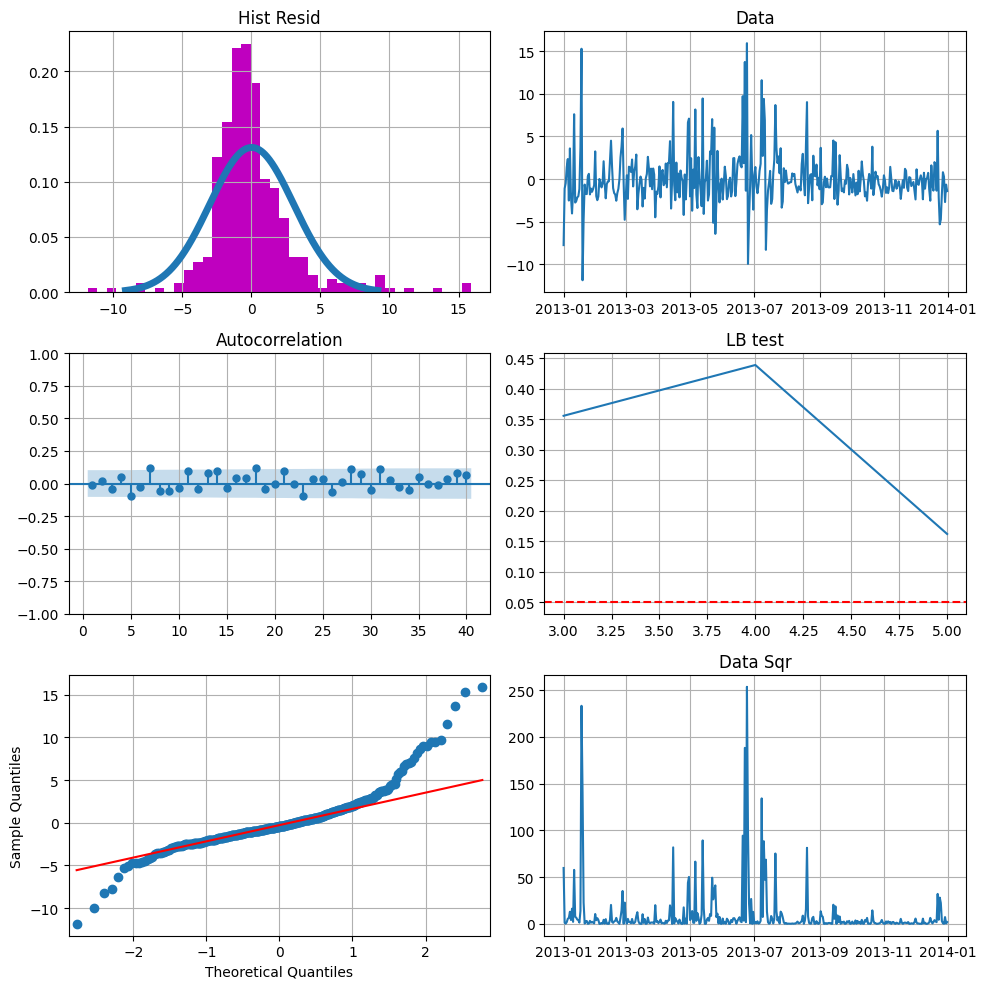

In [91]:
plot_diagnosticsTight3(resultsARIMA.resid,2)

365


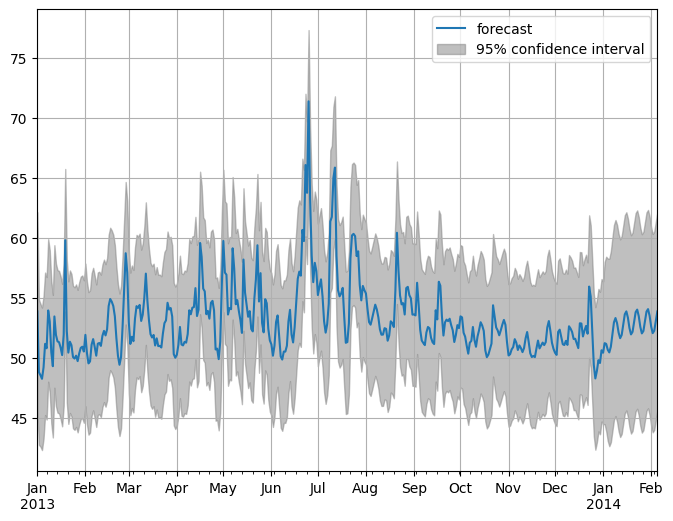

In [92]:
lastIdx = len(resultsARIMA.fittedvalues)
print(lastIdx)

# I need to create data to feed into exogenous matrix to be used for prediction:

startPt = 0
endPt = 400
nForecast = endPt - lastIdx

# coeff from Regression:
w1 = 1
w2 = 1
y1 = 0
y2 = 0

# In this example only weekly seasonality
exog = df_sincosFit(nForecast+1, w1,w2, y1,y2)


# This will proeduce the insampling,
# one-step prediction (fitted values) in addtion to one-step prediciton (mean)
# The mean is not constant! As we are overlayign it with the sin/cos periodic functions.

plot_predict(resultsARIMA, start=startPt,end=endPt , exog = exog[['w1Fit','w2Fit']])
plt.grid()
plt.show()

365
35


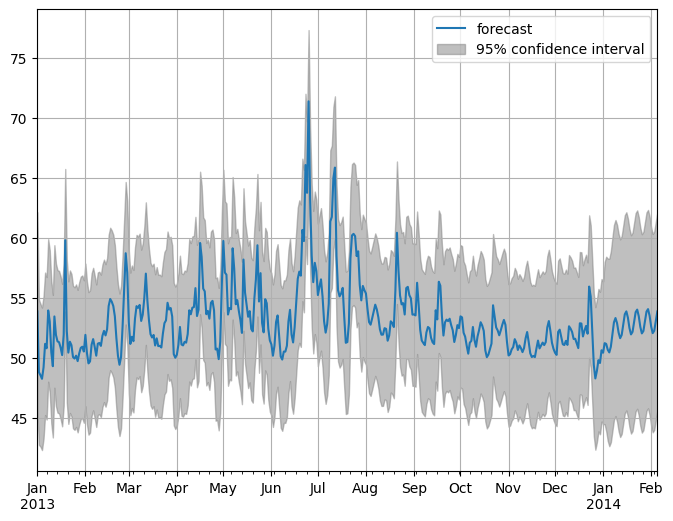

In [93]:
# I need to create data to feed into exogenous matrix to be used for prediction:
lastIdx = len(resultsARIMA.fittedvalues)
print(lastIdx)
startPt = 0
endPts = 400
nForecast = int(endPts - lastIdx)
print(nForecast)


w1 = 1
w2 = 1
y1 = 0
y2 = 0

exog = df_sincosFit(nForecast+1, w1,w2,y1,y2) # needs to add
plot_predict(
resultsARIMA, start=startPt,end=endPt , exog = exog[['w1Fit','w2Fit']])
plt.grid()
plt.show()

Bringing it all together - mean temperature, weekly trends, yearly
===

In [128]:
# Fitting seasonal functions (weekly and yearly) and mean temperature
# as regression external factors in conjunction with ARIMA.

results = pm.auto_arima(price,trace = True,
                        d=0, seasonal=False, with_intercept=True,
                        X = df[['meanTemp','y1','y2','w1','w2']])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1843.467, Time=3.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1984.790, Time=0.54 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1847.422, Time=2.43 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1898.004, Time=2.48 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2548.945, Time=0.58 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1857.511, Time=2.89 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1860.955, Time=3.01 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1864.882, Time=3.04 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1884.457, Time=2.66 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1846.097, Time=2.88 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1871.401, Time=2.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1879.614, Time=1.63 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1882.672, Time=2.18 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1891.958, Time=1.29 sec

Best model:  ARIMA(2,0,2)(0,0,0)

In [129]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -910.733
Date:                Wed, 15 Nov 2023   AIC                           1843.467
Time:                        17:33:34   BIC                           1886.366
Sample:                    01-01-2013   HQIC                          1860.515
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.3076      3.755      1.413      0.158      -2.053      12.668
meanTemp       0.1191      0.058      2.065      0.039       0.006       0.232
y1             0.3397      0.668      0.509      0.6

In [134]:
# Fitting seasonal functions as regression external factors in conjunction with ARIMA.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -910.895
Date:                Wed, 15 Nov 2023   AIC                           1843.789
Time:                        17:58:30   BIC                           1886.688
Sample:                    01-01-2013   HQIC                          1860.838
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.9633      1.314     38.793      0.000      48.388      53.538
meanTemp       0.1147      0.060      1.900      0.057      -0.004       0.233
y1             0.4618      0.797      0.579      0.5

Use model to forecast (though we see some limitations...)
===

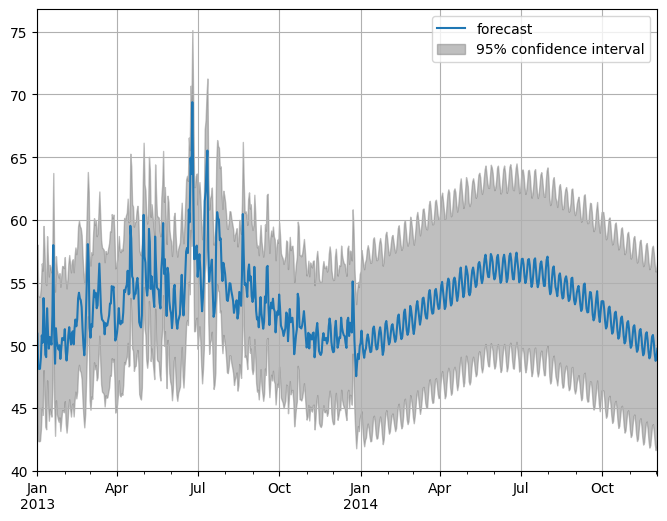

In [135]:
lastIdx = len(results.fittedvalues)
startPt = 0
endPts = 700
nForecast = endPts - lastIdx
w1 = 1
w2 = 1
y1 = 1
y2 = 1
exog = df_sincosFit(nForecast+1, w1, w2, y1, y2)
# needs to add 20 points for external regressor to predict.

plot_predict(results,start=0,end=endPts,exog=exog[['meanTempFit','y1Fit','y2Fit','w1Fit','w2Fit']])
plt.grid()
plt.show()

In [136]:
results.fittedvalues

date
2013-01-01    50.919138
2013-01-02    48.179172
2013-01-03    48.100761
2013-01-04    48.124751
2013-01-05    49.026872
                ...    
2013-12-27    47.530631
2013-12-28    48.567580
2013-12-29    49.306407
2013-12-30    48.899426
2013-12-31    49.930225
Length: 365, dtype: float64

Using splines to model the transform temperature
===

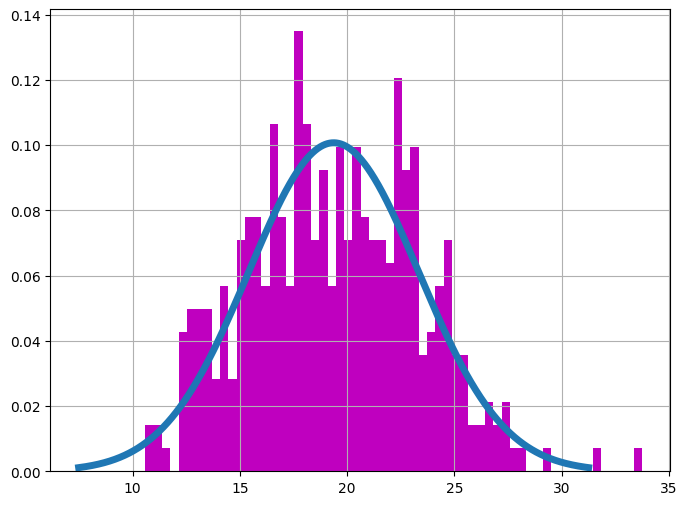

In [99]:
plt.hist(meanTemp.values, bins =60,color='m', density = True)
mu = meanTemp.mean()
sigma = meanTemp.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth= 5)
plt.grid()
plt.show()

In [100]:
x = meanTemp
dfree = 6 # degrees of freedom
n = dfree

percentiles = np.asarray([1/n*100,2/n*100,3/n*100,4/n*100, 5/n*100])
knots_6 = np.percentile(x, percentiles)
print(knots_6)
len(price)
meanTemp.values.max()

[15.4        17.51666667 19.25       21.35       23.21666667]


33.75

(365, 4)


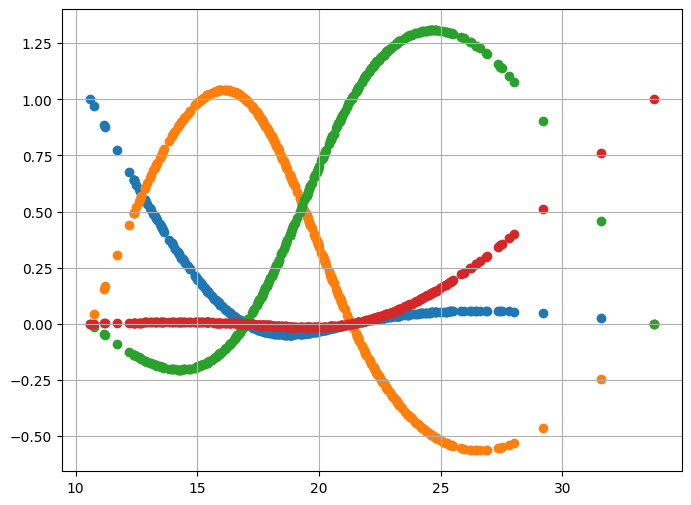

In [101]:
X1 = dmatrix("cr(x, df=4)-1", {"x": x}) #already chooses knots to be equally spaced quartiles.
X1=np.asarray(X1)
ns_p = pd.DataFrame(X1)
print(X1.shape)

plt.scatter(x, X1[:,0]);
plt.scatter(x, X1[:,1]);
plt.scatter(x, X1[:,2]);
plt.scatter(x, X1[:,3]);



plt.grid()
plt.show()

In [102]:
# Fit a linear regression
X1 = sm.add_constant(X1)
y = price
model = sm.OLS(y, X1)
lm = model.fit()
y_fitted= lm.fittedvalues
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     77.19
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           1.35e-38
Time:                        16:42:23   Log-Likelihood:                -955.32
No. Observations:                 365   AIC:                             1919.
Df Residuals:                     361   BIC:                             1934.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.3394      0.391    115.925      0.0

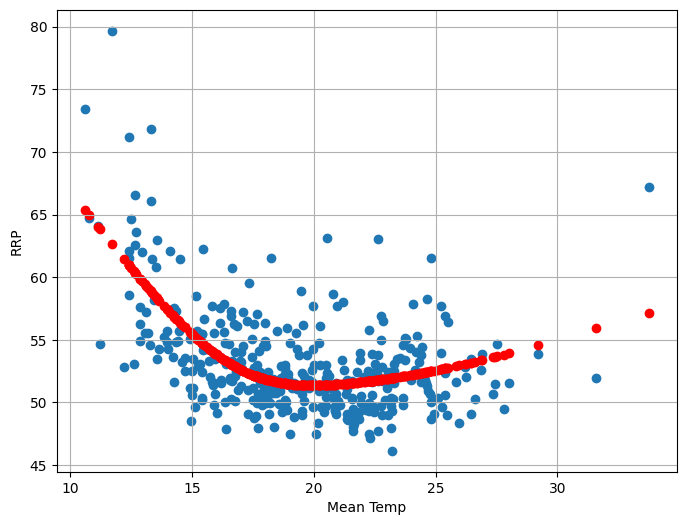

In [103]:
x = meanTemp.values
plt.grid()
plt.scatter(x=x,y=price)
plt.ylabel('RRP')
plt.xlabel('Mean Temp')
plt.scatter(x,y_fitted, color = 'red')
plt.show()

Now combine seasonality, with natural spline model for mean temperature as regressors for price
===

In [104]:
# Fit a linear regression
df.head()

,meanTemp,y1,y2,w1,w2
date,,,,,
2013-01-01,23.20,0.000000,1.000000,0.000000,1.000000
2013-01-02,21.60,0.017213,0.999852,0.781831,0.623490
2013-01-03,21.60,0.034422,0.999407,0.974928,-0.222521
2013-01-04,22.45,0.051620,0.998667,0.433884,-0.900969
2013-01-05,24.60,0.068802,0.997630,-0.433884,-0.900969


In [105]:
# Add results of natural spline as input data

df['x0'] = X1[:,0]
df['x1'] = X1[:,1]
df['x2'] = X1[:,2]
df['x3'] = X1[:,3]
df['x4'] = X1[:,4]


In [106]:
df.head()

,meanTemp,y1,y2,w1,w2,x0,x1,x2,x3,x4
date,,,,,,,,,,
2013-01-01,23.20,0.000000,1.000000,0.000000,1.000000,1.0,0.035621,-0.347634,1.250994,0.061018
2013-01-02,21.60,0.017213,0.999852,0.781831,0.623490,1.0,0.006601,-0.064423,1.051797,0.006025
2013-01-03,21.60,0.034422,0.999407,0.974928,-0.222521,1.0,0.006601,-0.064423,1.051797,0.006025
2013-01-04,22.45,0.051620,0.998667,0.433884,-0.900969,1.0,0.023709,-0.231379,1.176724,0.030947
2013-01-05,24.60,0.068802,0.997630,-0.433884,-0.900969,1.0,0.050579,-0.493610,1.307396,0.135635


In [138]:
arimaresult = pm.auto_arima(price, trace=True,seasonal=False, with_intercept=False, X = df[['y1','y2','w1','w2','x1','x2','x3','x4']],d=0)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1799.846, Time=5.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1872.725, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1805.431, Time=1.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1827.143, Time=1.66 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1798.026, Time=2.98 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1813.908, Time=4.37 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1796.264, Time=1.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.43 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1797.260, Time=1.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1798.264, Time=1.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 21.101 seconds


In [139]:
print(arimaresult.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -887.132
Date:                Wed, 15 Nov 2023   AIC                           1796.264
Time:                        18:33:17   BIC                           1839.163
Sample:                    01-01-2013   HQIC                          1813.312
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y1             0.5511      0.621      0.888      0.375      -0.666       1.768
y2            -2.3859      0.758     -3.146      0.002      -3.872      -0.900
w1             0.5833      0.244      2.387      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -887.132
Date:                Wed, 15 Nov 2023   AIC                           1798.264
Time:                        18:33:29   BIC                           1845.063
Sample:                    01-01-2013   HQIC                          1816.862
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.7258      0.366    122.252      0.000      44.009      45.443
y1             0.5505      0.621      0.886      0.375      -0.667       1.768
y2            -2.3854      0.758     -3.145      0.0

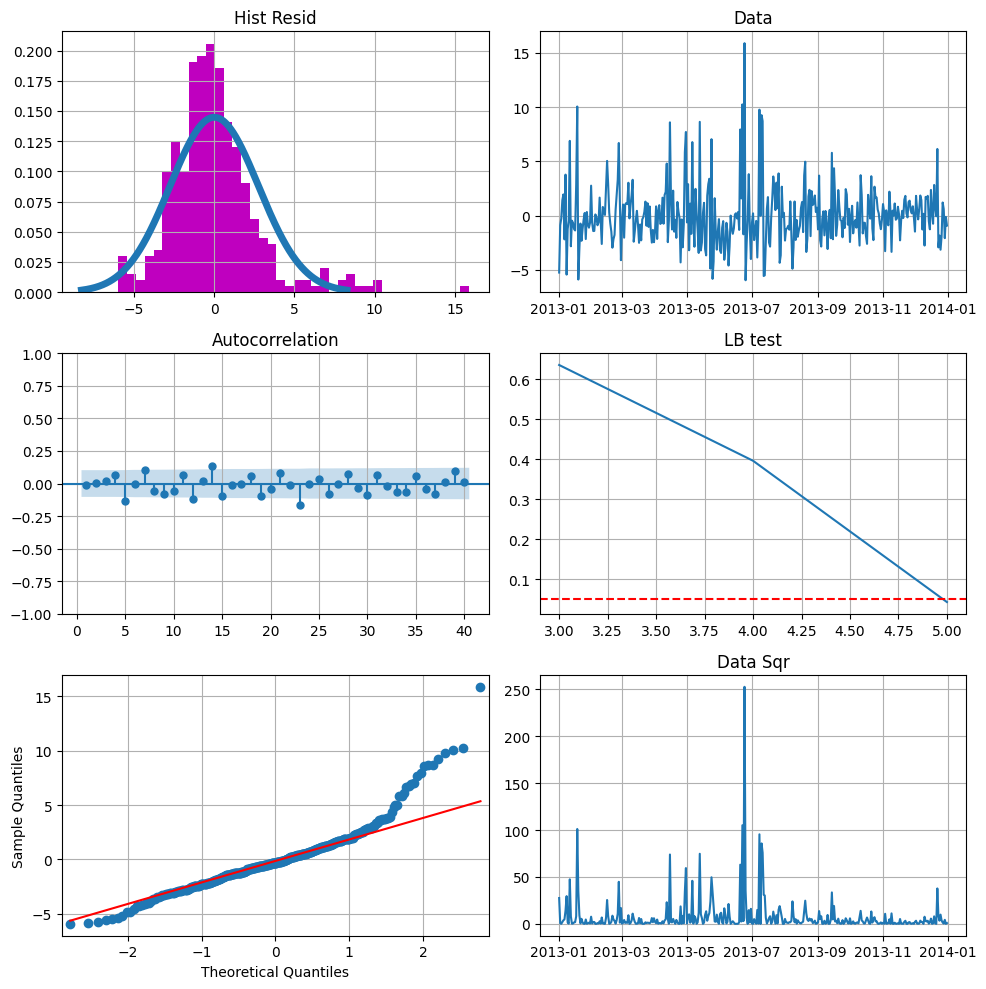

In [140]:
model = ARIMA(price, trend = 'c', order=(1,0,1), exog = df[['y1','y2','w1','w2','x1','x2','x3','x4']]) #
results = model.fit() #Notice that since we added a constant to X1, need to set trend 'nc', else remove from regressor
print(results.summary());
y_fitted = results.fittedvalues
plot_diagnosticsTight3(results.resid,2)

A lot of work to then generate the relevant data for future predictions
===

In [141]:
# Generate data to feed to forecast (required for exogeneous variables)
def df_sincosFit2(N,w1,w2,y1,y2):

    weeklyFit = np.zeros(N)
    weekly2Fit = np.zeros(N)
    yearlyFit = np.zeros(N)
    yearly2Fit = np.zeros(N)
    meanTempFit = np.zeros(N)


   # meanTempFit = meanTempFit*meanTempNext[0]
    x1Fit = np.ones(N)*df['x1'][-1]
    x2Fit = np.ones(N)*df['x2'][-1]
    x3Fit = np.ones(N)*df['x3'][-1]
    x4Fit = np.ones(N)*df['x4'][-1]

    for i in range(N):
        yearlyFit[i] = y1*np.sin(2*np.pi*i/365)
        yearly2Fit[i] = y2*np.cos(2*np.pi*i/365)
        weeklyFit[i] = w1*np.sin(2*np.pi*i/7)
        weekly2Fit[i] = w2*np.cos(2*np.pi*i/7)

    x = meanTempFit

    #XFit = dmatrix("cr(x, df=4)-1", {"x": x}) #already choosed knots to be equally spaced quartiles.
    #print(XFit)
    # Create dataframe
    #myList = [meanTempFit, yearlyFit, yearly2Fit, weeklyFit, weekly2Fit, XFit[:,0],XFit[:,1],XFit[:,2],XFit[:,3]]
    myList = [meanTempFit, yearlyFit, yearly2Fit, weeklyFit, weekly2Fit, x1Fit,x2Fit,x3Fit,x4Fit]
    names = ['meanTempFit','y1Fit','y2Fit','w1Fit','w2Fit','x1','x2','x3','x4']
    myDict = dict(zip(names, myList))
    dfFit = pd.DataFrame({ key:pd.Series(value) for key, value in myDict.items()})
    return dfFit

#dfFit = df_sincosFit2(20)



In [112]:
lastIdx = len(results.fittedvalues)
endPt = 700
startPt = 0
nForecast = endPt - lastIdx

y1 = 1
y2 = 1
w1 = 1
w2 = 1

exog = df_sincosFit2(nForecast+1,w1,w2,y1,y2)

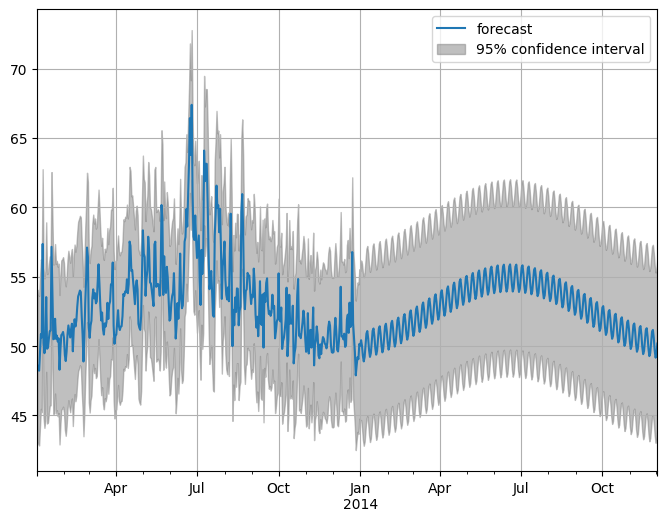

In [113]:
plot_predict(results,start=1,end=endPt, exog = exog[['y1Fit','y2Fit','w1Fit','w2Fit','x1','x2','x3','x4']] )#,
plt.grid()
plt.show()

SARIMAX - Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
===

In [114]:
model = SARIMAX(price,  trend = 'c', order=(1,0,1),  seasonal_order=(1, 0, 1, 7))
results = model.fit(disp = False)
print(results.summary());
y_fitted = results.fittedvalues

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -917.988
Date:                           Wed, 15 Nov 2023   AIC                           1847.976
Time:                                   16:46:15   BIC                           1871.375
Sample:                                        0   HQIC                          1857.275
                                           - 365                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0300      1.200      2.525      0.012       0.678       5.382
ar.L1          0.7417      0.033     22.799

In [115]:
?SARIMAX

In [116]:
model = SARIMAX(price, order=(1,0,1), trend = 'c')
arima_result = model.fit(disp = False)
print(arima_result.summary());
y_fitted_arima = arima_result.fittedvalues

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -931.455
Date:                Wed, 15 Nov 2023   AIC                           1870.909
Time:                        16:53:02   BIC                           1886.509
Sample:                             0   HQIC                          1877.109
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.8642      1.555      6.988      0.000       7.817      13.911
ar.L1          0.7955      0.029     27.748      0.000       0.739       0.852
ma.L1         -0.2243      0.051     -4.395      0.0

In [117]:
# But results are worth it... more realistic forecast for mean

# Create SARIMA mean forecast
sarima_pred = results.get_prediction(start= 300, end = 400)
sarima_mean = sarima_pred.predicted_mean

# Create arima mean forecast
arima_pred = arima_result.get_prediction(start=300, end = 400)
arima_mean = arima_pred.predicted_mean

# Conf interval
sarima_pred.conf_int

fut = results.get_forecast(101)
mean_se = fut.se_mean
print(mean_se)

[2.9919072  3.43408311 3.65457463 3.77036796 3.83257162 3.86636157
 3.88482324 3.9592012  3.98823447 4.00411516 4.01282392 4.01760632
 4.02023457 4.02167957 4.04740902 4.05646913 4.06144424 4.06417832
 4.06568149 4.0665081  4.06696272 4.0809155  4.08571621 4.08835455
 4.0898051  4.0906028  4.09104152 4.09128283 4.09953722 4.10236789
 4.10392413 4.10477993 4.1052506  4.10550949 4.10565188 4.11061246
 4.11231335 4.11324866 4.11376306 4.11404599 4.11420161 4.11428722
 4.11727851 4.11830438 4.11886858 4.11917889 4.11934958 4.11944347
 4.11949511 4.12130085 4.12192025 4.12226092 4.12244831 4.12255138
 4.12260807 4.12263926 4.12372987 4.12410401 4.12430979 4.12442299
 4.12448525 4.1245195  4.12453834 4.12519722 4.12542326 4.1255476
 4.12561599 4.12565361 4.12567431 4.12568569 4.1260838  4.12622039
 4.12629553 4.12633685 4.12635959 4.12637209 4.12637897 4.12661955
 4.12670209 4.12674749 4.12677247 4.12678621 4.12679376 4.12679792
 4.12694331 4.12699319 4.12702063 4.12703573 4.12704403 4.12704

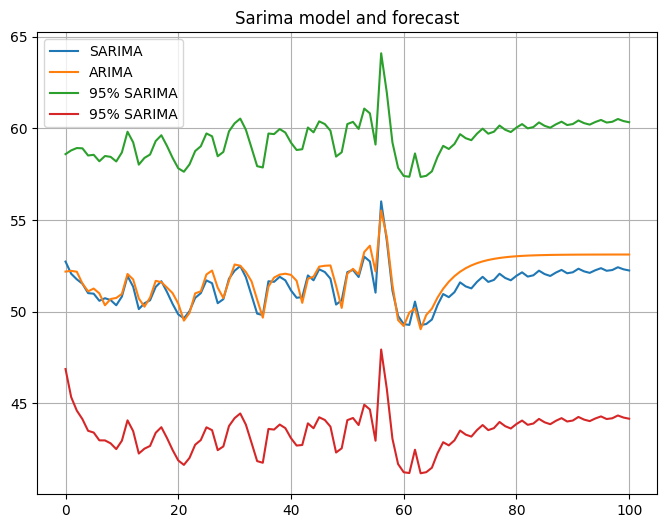

In [119]:
# Plot mean ARIMA and SARIMA predictions and observed (assuming Gaussian White Noise)
plt.plot(sarima_mean, label='SARIMA')
plt.plot(arima_mean, label='ARIMA')
bound = mean_se*1.96
plt.plot(sarima_mean+bound, label='95% SARIMA')
plt.plot(sarima_mean-bound, label='95% SARIMA')
plt.title('Sarima model and forecast')
plt.legend()
plt.grid()
plt.show()

In [120]:
?results.get_prediction

In [121]:

print(sarima_pred.summary_frame().head())

y       mean   mean_se  mean_ci_lower  mean_ci_upper
0  52.728926  2.991907      46.864896      58.592956
1  52.066013  2.991907      46.201983      57.930044
2  51.761650  2.991907      45.897620      57.625681
3  51.519471  2.991907      45.655440      57.383501
4  51.007208  2.991907      45.143178      56.871239


In [122]:
52.761790+1.96*2.994721

58.631443159999996

In [123]:
52.761790-1.96*2.994721

46.89213684

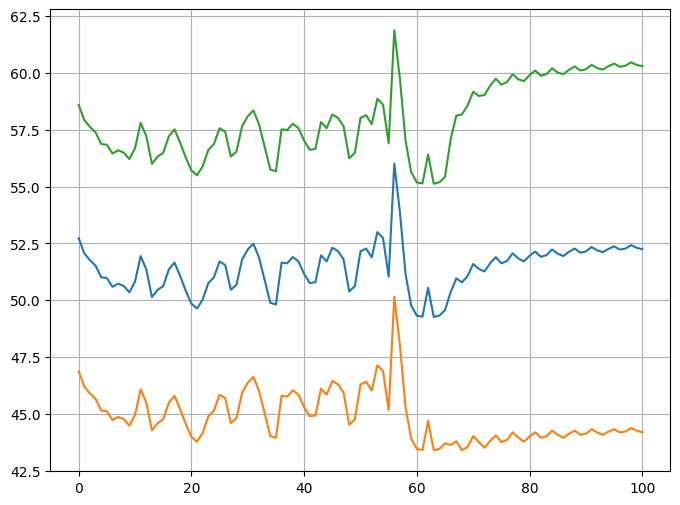

In [124]:
low = sarima_pred.summary_frame()['mean_ci_lower']
up = sarima_pred.summary_frame()['mean_ci_upper']
mean = sarima_pred.summary_frame()['mean']

plt.plot(mean)
plt.plot(low)
plt.plot(up)
plt.grid()
plt.show()

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -881.698
Date:                           Wed, 15 Nov 2023   AIC                           1781.396
Time:                                   18:43:19   BIC                           1816.495
Sample:                               01-01-2013   HQIC                          1795.345
                                    - 12-31-2013                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            59.8663      1.485     40.308      0.000      56.955      62.777
x2            51.8547      1.388     37.362

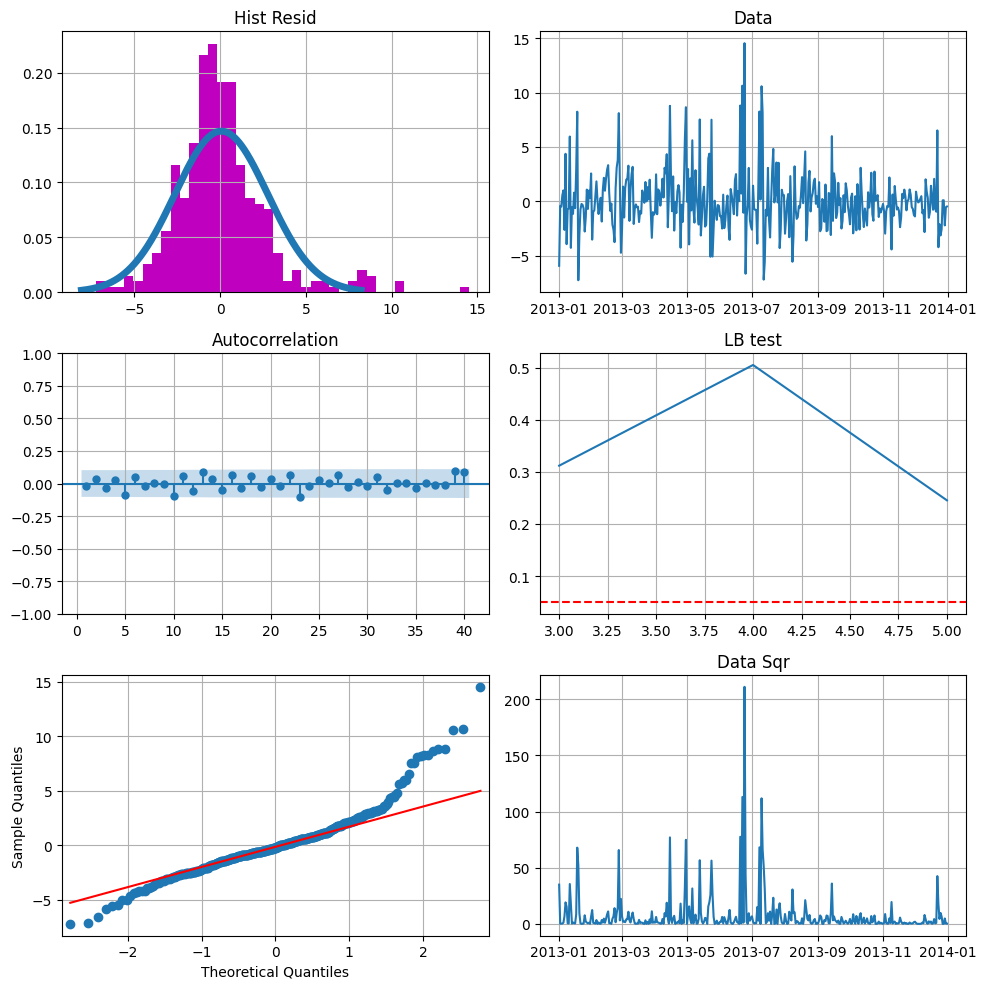

In [143]:
model = SARIMAX(price, order=(1,0,1),  seasonal_order=(1, 0, 1, 7), exog = df[['x1','x2','x3','x4']])
results = model.fit(trend = 'c',disp = False)
print(results.summary());
y_fitted = results.fittedvalues
plot_diagnosticsTight3(results.resid,2)

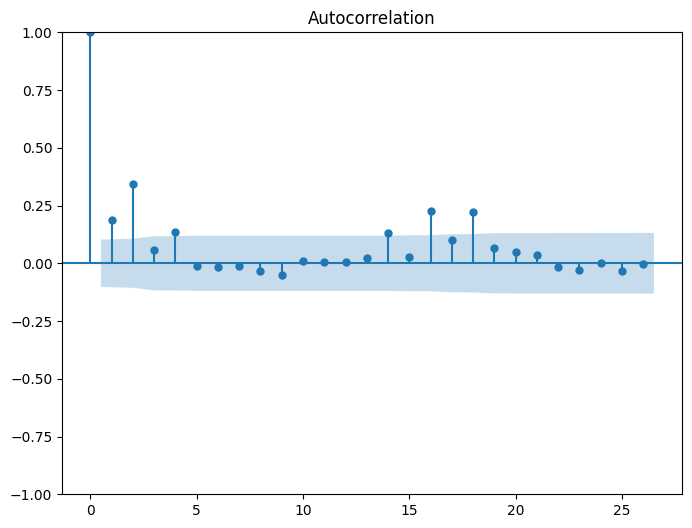

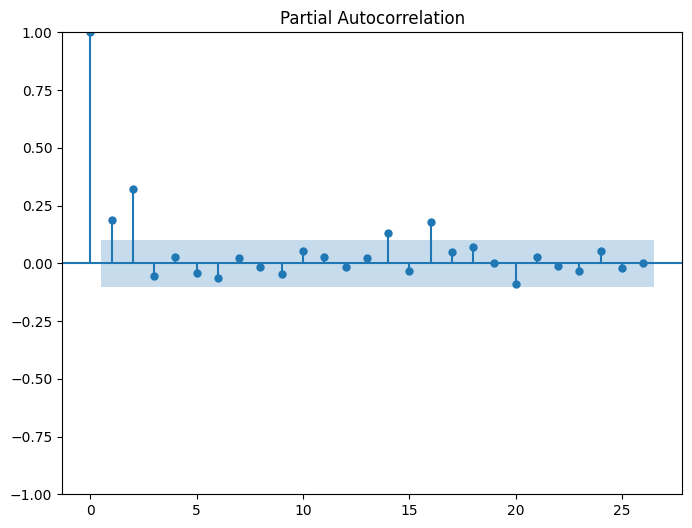

In [144]:
plot_acf(results.resid**2);
plot_pacf(results.resid**2);